In [19]:
import pipeline_vsdi.io as io
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

Exception ignored in: <function tqdm.__del__ at 0x10bee91c0>
Traceback (most recent call last):
  File "/Users/davide/mambaforge/envs/pipeline_vsdi/lib/python3.11/site-packages/tqdm/std.py", line 1145, in __del__
    self.close()
  File "/Users/davide/mambaforge/envs/pipeline_vsdi/lib/python3.11/site-packages/tqdm/notebook.py", line 283, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


In [27]:
def read_raw_file_slice(filename, h, w, start_frame=0,end_frame=None, precision='>f'): 

    """
    Read a slice of frames from a raw binary file and reshape into a 3D array.

    This function reads a specified range of frames from a raw binary file, interprets
    the data according to the specified precision, and reshapes it into a 3D numpy array
    representing the frames.

    Parameters:
    filename (str): The name of the raw binary file to read.
    h (int): The height of each frame.
    w (int): The width of each frame.
    start_frame (int, optional): The starting frame index (default is 0).
    end_frame (int, optional): The ending frame index (default is None, which indicates
                              the last frame of the slice).
    precision (str, optional): The data precision format used in the binary file
                              (default is '>f', which represents big-endian 4-byte float).

    Returns:
    numpy.ndarray: A 3D numpy array containing the frames, with dimensions (h, w, n_frames).

    Note:
    - The 'order="F"' argument is used to reshape the data in Fortran order, which is column-major
      like the memory layout of numpy arrays.

    Example:
    frame_slice = read_raw_file_slice('file.raw', h=256, w=256, start_frame=0, end_frame=100,
                                      precision='>f')
    """

    n_frames = end_frame - start_frame
    element_size = np.dtype(precision).itemsize # byte size of a single pixel
    offset_bytes = h * w * start_frame *element_size # offset for the file stream
    
    elements_to_read = h*w*n_frames # number of elements to read from stream
    
    with open(filename, "rb") as filestream:
        filestream.seek(offset_bytes) # starts from computed offset
        img = np.fromfile(filestream, dtype=precision,count=elements_to_read)
    img = np.reshape(img, [h, w, n_frames], order="F")
    
    return img

def read_vsdi_file(filename,start_frame = 0, end_frame=None, precision='>f'):
    """
    Reads a VSDI (Voltage-Sensitive Dye Imaging) file and returns the video as a numpy array.
    The name of the file has to be in the following format:
    'session_info_NFfr_FRHz_WWxHH_preprocessing_info.raw'
    where:
    NF: number of frames
    FR: frame rate
    WW: frame width in pixels
    HH: frame height in pixels



    Parameters:
        filename (str): The name of the VSDI file to be read.
        precision (str, optional): The precision of the data stored in the file.
            It determines how the data is interpreted. The default value is '>f'
            which stands for big-endian single-precision floating-point format.
        start_frame (int,optional): Frame to start reading the video from. Default value is 0.
        end_frame (int,optional): Frame to end the video reading at. If not provided, the video will be read
            until the end.

    Returns:
        video (ndarray): A NumPy array containing the video read from the VSDI file with shape (h x w x n_frames).

    Raises:
        FileNotFoundError: If the specified filename does not exist.

    Example:
        filename = 'block1_A03_day2_75026fr_125Hz_480x300_Bandpass_Cheby_high_0.5_9FHz_D_F0_.raw'
        video = read_vsdi_file(filename)
    """

    if end_frame is None:
        end_frame = int(filename.split('x')[0].split('fr')[0].split('_')[-1])

        

    w = int(filename.split('x')[1].split('_')[0])
    h = int(filename.split('x')[0].split('_')[-1])
    video = read_raw_file_slice(filename, h, w,
                                start_frame = start_frame,
                                end_frame = end_frame,
                                precision=precision)

    return video


def read_and_downsample_vsdi(filename, stride, start_frame = 0, end_frame= None,
                             precision='>f',batch_size=1000):
    """
    Read from a VSDI .raw file, and downsample images with specified stride.

    This function reads a specified range of frames from a VSDI file,
    downsampling the frames using a given stride, and returns the downsampled frames
    in a single array.

    Parameters:
    filename (str): The name of the VSDI file to read.
    stride (int): The downsampling stride for both width and height of frames.
    start_frame (int, optional): The starting frame index (default is 0).
    end_frame (int, optional): The ending frame index (default is None, which indicates
                              the last frame of the file).
    precision (str, optional): The data precision format to read from the file
                              (default is '>f', which represents big-endian 4-byte float).
    batch_size (int, optional): The number of frames to read and process in each batch
                              (default is 1000). This roughly correspond to a 1Gb memory load at
                              all times. If more memory is available, batch_size can be increased.

    Returns:
    numpy.ndarray: A 3D numpy array containing the downsampled frames stacked along the
                  third dimension.

    Note:
    - The downsampling is performed by skipping pixels in both width and height of each frame.
    - The resulting frames are stored in a single array, with the third dimension containing
      the downsampled frames.
    - The function uses the provided batch size to read and process frames in
      smaller chunks, to be able to work with larger-than-memory files.

    Example:
    downsampled_video = read_and_downsample_vsdi('Block1_A02_d7_mc_27718fr_125Hz_480x300_Bandpass_Cheby_high_0.5_9FHz_D_F0_.raw', 
                                                  stride=2, start_frame=0,end_frame=100, precision='>f', batch_size=500)
    """

    

    out_video = []
    
    element_size = np.dtype(precision).itemsize

    w = int(filename.split('x')[1].split('_')[0])
    h = int(filename.split('x')[0].split('_')[-1])
    
    if end_frame is None:
        end_frame = int(filename.split('x')[0].split('fr')[0].split('_')[-1])


    n_frames = end_frame-start_frame

    start_frame = 0
    n_batches = int(np.ceil(n_frames/batch_size))

    for i in tqdm(range(n_batches)):
        end_frame = start_frame + batch_size
        if end_frame > n_frames:
            end_frame = n_frames
            
        video = read_raw_file_slice(filename, h, w,
                                start_frame = start_frame,
                                end_frame = end_frame,
                                precision=precision)
        out_video.append(video[::stride,::stride,:])
        start_frame = end_frame

    out_video = np.dstack(out_video)


    return out_video

In [12]:
raw_file = '/Volumes/imaging1/morgane/neuronal_dataset/Cue_dataset/A02_Gaudi/day7/Block1_A02_d7_mc_27718fr_125Hz_480x300_Bandpass_Cheby_high_0.5_9FHz_D_F0_.raw'


In [25]:
A = read_and_downsample_vsdi(raw_file,stride=8,end_frame=2001)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:36<00:00, 12.16s/it]


In [26]:
A.shape

(60, 38, 2001)

In [17]:
B.shape

(60, 38, 2000)

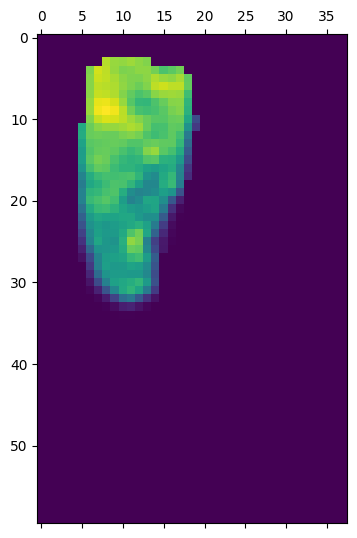

In [23]:
plt.matshow(B[:,:,1500])

# import matplotlib.pyplot as plt
plt.matshow(A[:,:,4])